## 🔹 Initialisation du notebook
Chargement des fonctions utilitaires et des données à partir de `src/data_loader.py`. Et affichage des statistiques descriptives.


In [2]:
import sys
sys.path.append("../src")  # pour accéder aux modules dans src/

from data_loader import load_all_data
from utils import afficher_statistiques

# Chargement des données
fs1, ps2, profile = load_all_data()

# Statistiques pour chaque fichier
afficher_statistiques("FS1", fs1)
afficher_statistiques("PS2", ps2)
afficher_statistiques("Profile", profile)


--- Statistiques pour FS1 ---
Dimensions (lignes, colonnes) : (2204, 600)
Types de variables :
8.99       float64
0.77       float64
0.641      float64
0.006      float64
0          float64
            ...   
7.823      float64
7.963.1    float64
7.876.1    float64
7.738.2    float64
8.036.1    float64
Length: 600, dtype: object

Aperçu des premières lignes :
    8.99   0.77  0.641  0.006      0    0.1  0.001  0.003  0.001.1  0.001.2  \
0  8.919  0.815  0.709  0.009  0.004  0.000  0.001  0.000    0.000    0.001   
1  9.179  0.683  0.528  0.008  0.003  0.001  0.003  0.003    0.004    0.006   
2  9.034  0.728  0.595  0.009  0.001  0.004  0.003  0.003    0.003    0.001   
3  8.729  0.705  0.446  0.014  0.007  0.003  0.001  0.003    0.001    0.000   
4  9.044  0.724  0.485  0.006  0.000  0.000  0.000  0.000    0.001    0.003   

   ...  7.743  7.992  7.919.1  7.773.3  7.955.1  7.823  7.963.1  7.876.1  \
0  ...  7.831  8.003    7.923    7.745    7.867  7.747    7.969    7.969   
1  ...  7.

### Affichage de la pression et du débit au cours des 3 premiers cycles où la condition de la valve est optimale (100%) et non optimale

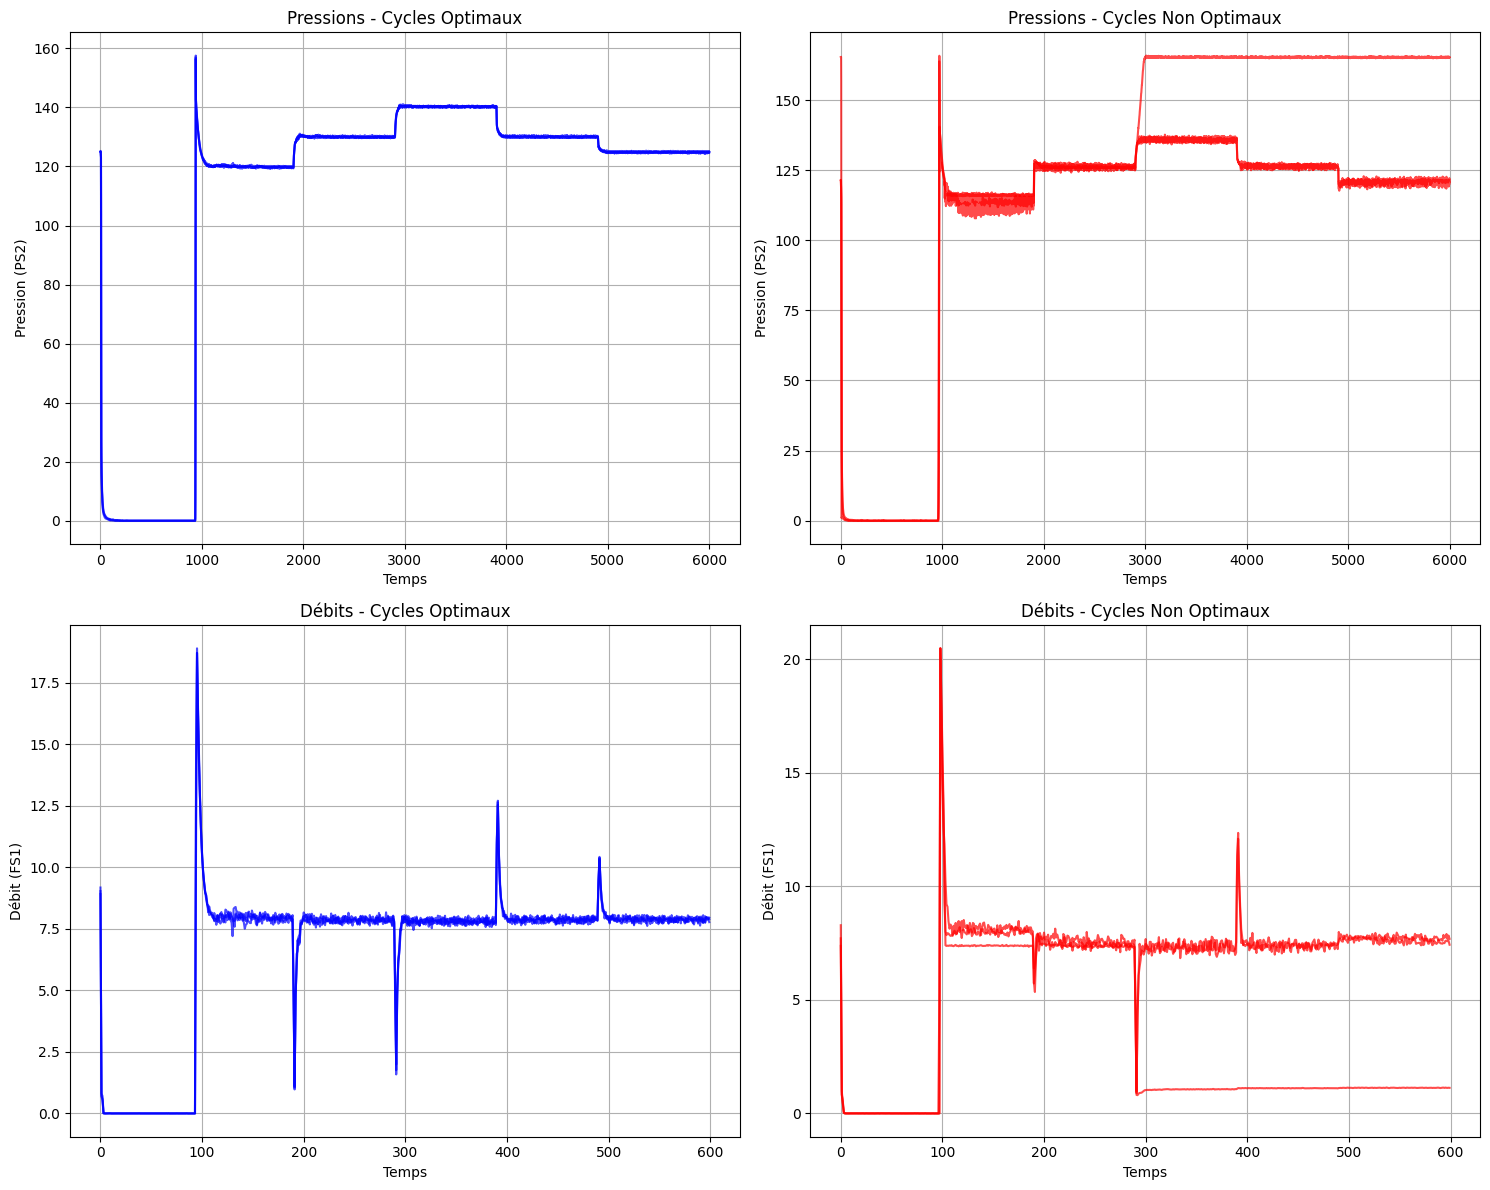

In [3]:
from utils import  select_cycles, extract_segments, plot_data

# Sélection des cycles
selected_indices = select_cycles(profile)

# Extraction des segments de pression et de débit pour les cycles sélectionnés
pressure_segments, flow_segments, labels = extract_segments(profile, ps2, fs1, selected_indices)

# Visualisation 
plot_data(pressure_segments, flow_segments, labels)


## 1. Analyse des Courbes de Pression

### Cycles Optimaux
- Les courbes montrent une superposition entre elles, indiquant une forte répétabilité du processus
- On observe 3 phases distinctes dans chaque cycle :
  * Une phase de montée rapide en pression
  * Un plateau de stabilisation
  * Une phase de descente contrôlée
- L'amplitude des pics est constante entre les cycles
- Absence de fluctuations parasites pendant les phases stables

### Cycles Non-Optimaux
- Les courbes présentent des divergences entre elles
- Irrégularités notables :
  * Variations d'amplitude entre les cycles
  * Pics de pression non uniformes
  * Oscillations pendant les phases qui devraient être stables
  * Transitions moins nettes entre les phases
- Certains cycles montrent des comportements non habituels, particulièrement dans la phase de montée en pression

## 2. Analyse des Courbes de Débit

### Cycles Optimaux
- Profils de débit très cohérents entre les cycles
- Les transitions sont synchronisées avec les changements de pression
- Excellente répétabilité du pattern entre les cycles

### Cycles Non-Optimaux
- Disparités importantes entre les cycles
- Anomalies observées :
  * Fluctuations irrégulières pendant les phases stables
  * Réponses asynchrones par rapport aux changements de pression
  * Amplitudes variables entre les cycles
  * Transitions moins prévisibles
- Certains cycles montrent des perturbations significatives dans le maintien du débit constant


## 3. Déductions pour la Maintenance Prédictive

- La forte répétabilité des cycles optimaux montre une référence de bon fonctionnement
- On voit l'importance des transitions comme indicateurs de défaillance
- Il est nécessaire de surveiller la synchronisation pression-débit


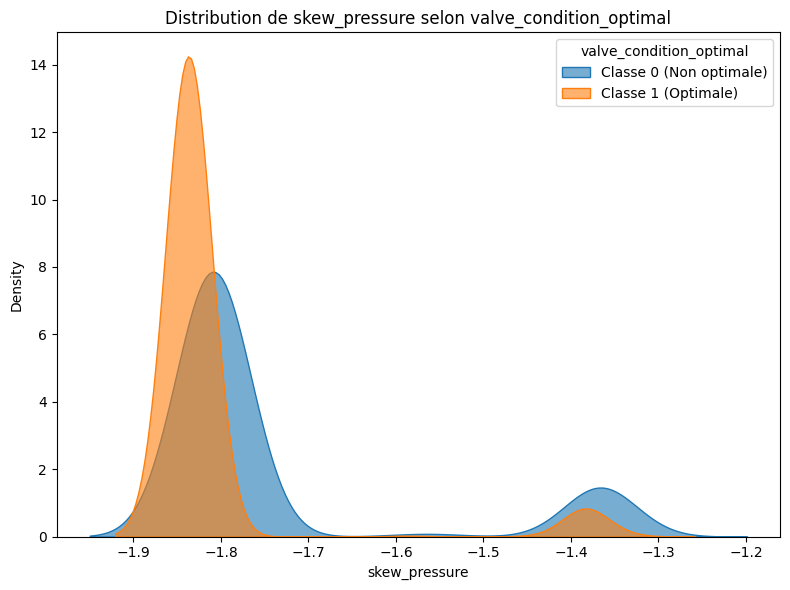

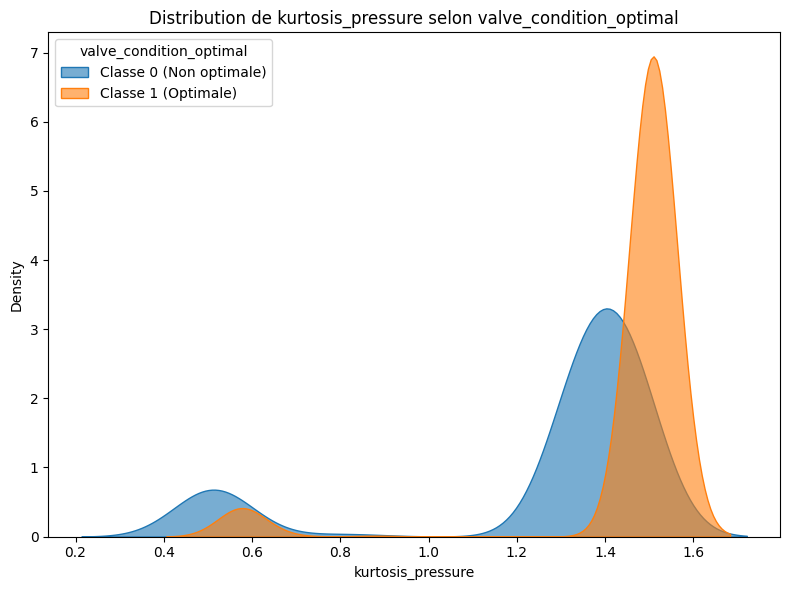

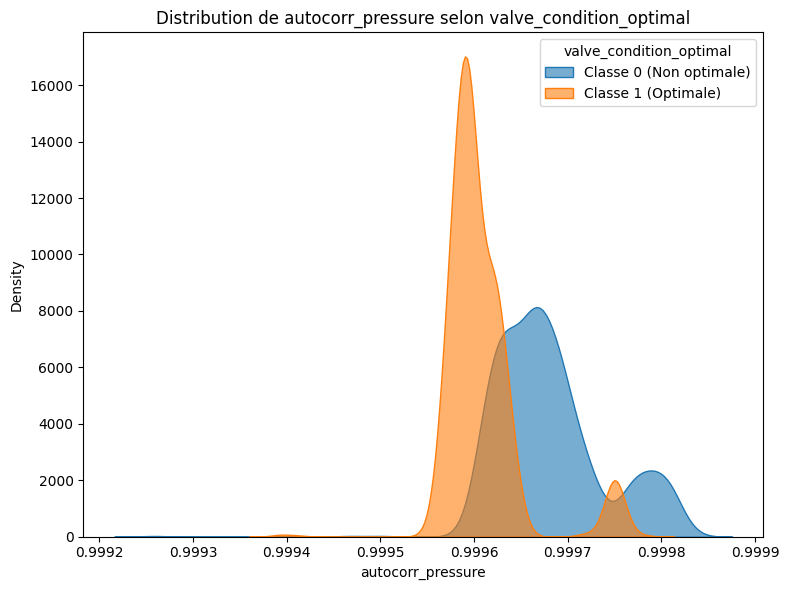

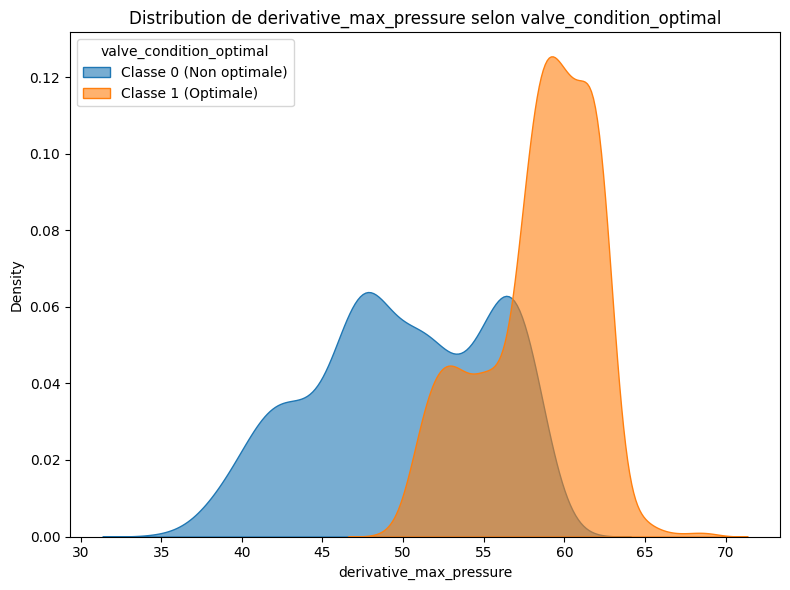

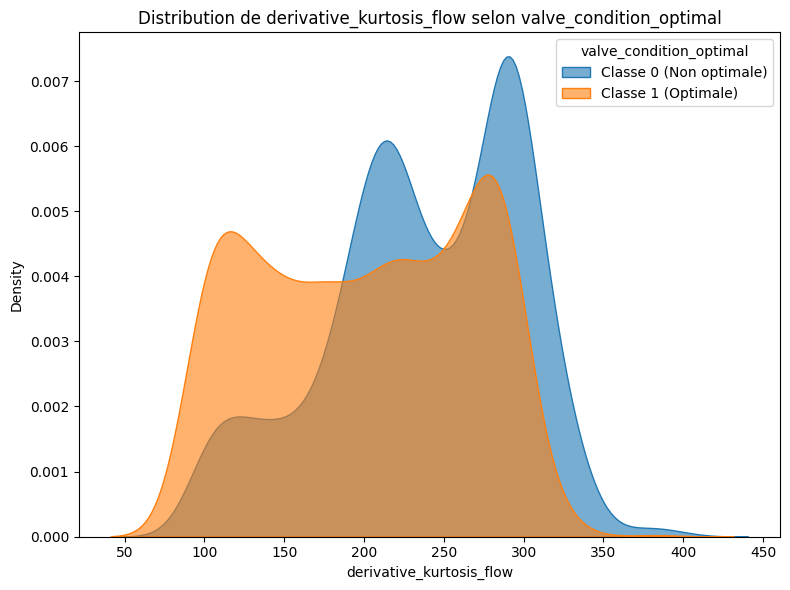

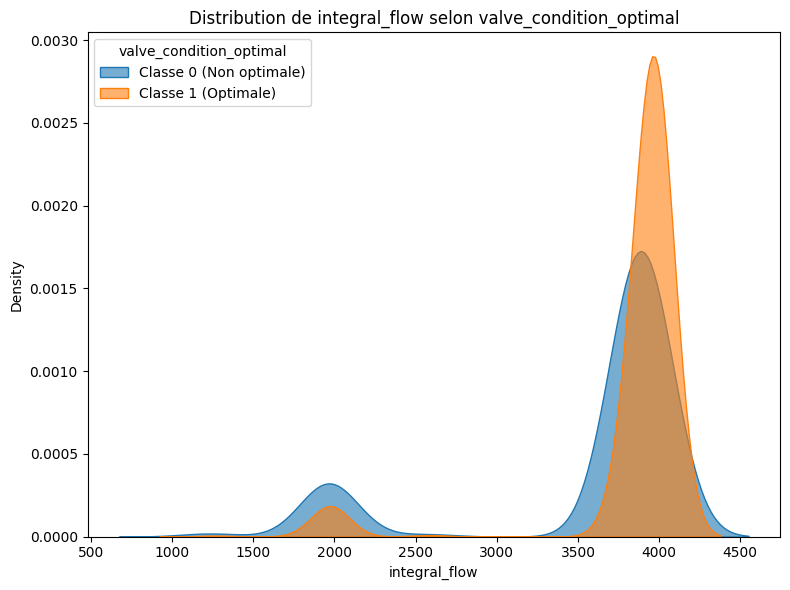

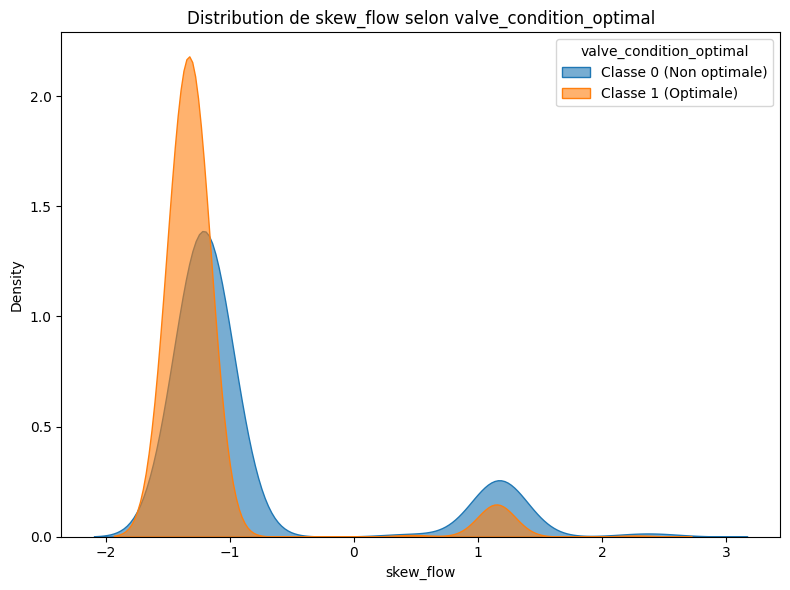

In [4]:
from utils import create_target_variable, extract_segments, plot_feature_distribution
from features import extract_features
import pandas as pd

profile = create_target_variable(profile)

selected_indices = profile.index  

pressure_segments, flow_segments, labels = extract_segments(profile, ps2, fs1, selected_indices)

features_list = []
for p_segment, f_segment in zip(pressure_segments, flow_segments):
    features = extract_features(p_segment, f_segment)
    features_list.append(features)

df_features = pd.DataFrame(features_list)

df_target = profile.loc[selected_indices, 'valve_condition_optimal'].reset_index(drop=True)

df_features['valve_condition_optimal'] = df_target

feature_columns = df_features.columns[:-1]  # Exclure la colonne de la variable cible
plot_feature_distribution(df_features, 'valve_condition_optimal', feature_columns)

### Features selectionnés :

Après étude des résultats obtenus via la fonction extract_features dans tests/test_features.py on décide de garder les features les plus pertinents : 

- skew_pressure : mesure l’asymétrie de la distribution de la pression.
- kurtosis_pressure : mesure l’aplatissement ou la concentration des valeurs de pression autour de la moyenne.
- autocorr_pressure : mesure la similarité de la pression avec un décalage dans le temps.
- derivative_max_pressure : valeur maximale de la dérivée de la pression, indiquant la montée la plus rapide.
- derivative_kurtosis_flow : aplatissement de la dérivée du débit, utile pour détecter des pics soudains ou instabilités dans la variation du débit.
- integral_flow : somme de toutes les valeurs du débit, représentant le volume total de fluide passé pendant un cycle.
- skew_flow : mesure l’asymétrie de la distribution du débit.

Taille de l'ensemble d'entraînement : 2000
Taille de l'ensemble de test : 204
Random Forest:
Classification Report :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       102
           1       1.00      0.99      1.00       102

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



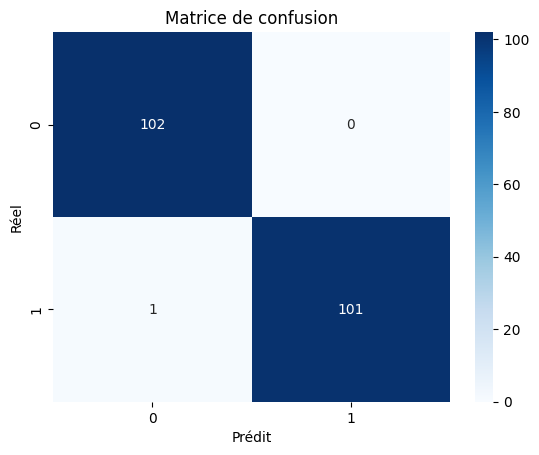


Logistic Regression:
Classification Report :
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       102
           1       0.80      0.76      0.78       102

    accuracy                           0.78       204
   macro avg       0.78      0.78      0.78       204
weighted avg       0.78      0.78      0.78       204



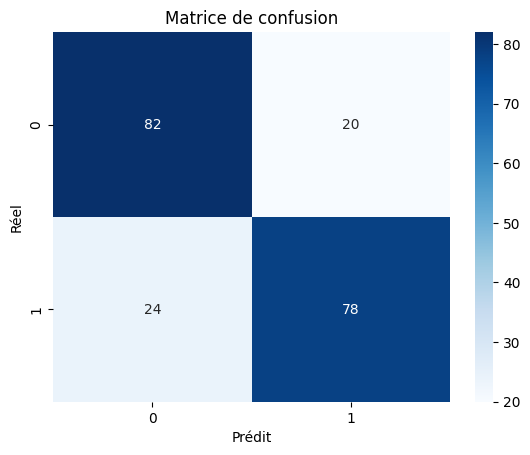


Support Vector Machine:
Classification Report :
              precision    recall  f1-score   support

           0       0.74      0.34      0.47       102
           1       0.57      0.88      0.69       102

    accuracy                           0.61       204
   macro avg       0.66      0.61      0.58       204
weighted avg       0.66      0.61      0.58       204



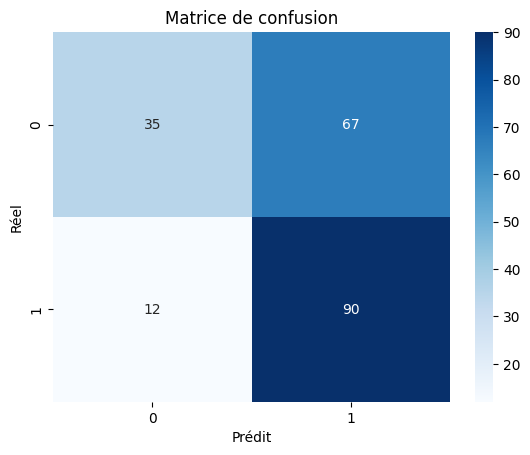


K-Nearest Neighbors:
Classification Report :
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       102
           1       0.89      0.84      0.86       102

    accuracy                           0.87       204
   macro avg       0.87      0.87      0.87       204
weighted avg       0.87      0.87      0.87       204



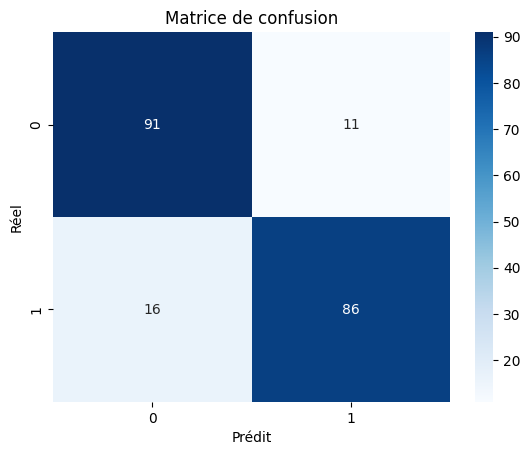


Gradient Boosting:
Classification Report :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       102
           1       1.00      0.99      1.00       102

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



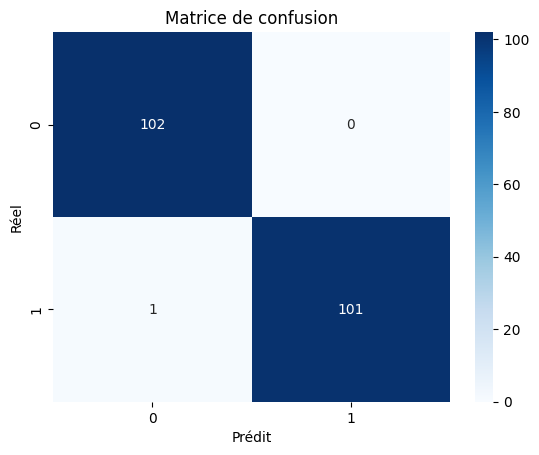

In [5]:
from sklearn.model_selection import train_test_split

X = df_features.drop(columns=['valve_condition_optimal'])
y = df_features['valve_condition_optimal']

# Division en jeu d'entraînement (2000) et jeu de test (204)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=204, random_state=42)

# Affichage de la taille des ensembles
print(f"Taille de l'ensemble d'entraînement : {X_train.shape[0]}")
print(f"Taille de l'ensemble de test : {X_test.shape[0]}")

from train_model import (
    train_random_forest,
    train_logistic_regression,
    train_svm,
    train_knn,
    train_gradient_boosting
)
from evaluate import evaluate_model

# Entraînement des modèles
rf_model = train_random_forest(X_train, y_train)
lr_model = train_logistic_regression(X_train, y_train)
svm_model = train_svm(X_train, y_train)
knn_model = train_knn(X_train, y_train)
gb_model = train_gradient_boosting(X_train, y_train)

# Évaluation
print("Random Forest:")
evaluate_model(rf_model, X_test, y_test)

print("\nLogistic Regression:")
evaluate_model(lr_model, X_test, y_test)

print("\nSupport Vector Machine:")
evaluate_model(svm_model, X_test, y_test)

print("\nK-Nearest Neighbors:")
evaluate_model(knn_model, X_test, y_test)

print("\nGradient Boosting:")
evaluate_model(gb_model, X_test, y_test)



### Modèles les plus performants :
On remarque que les deux modèles qui marchent le mieux sont Random forest et Gradient boosting, les deux modèles d'ensembles à base d'arbres de décision.
On gardera le modèle Gradient boosting arbitrairement, car les deux ont sensiblements les mêmes performances

In [6]:
import os

os.makedirs('../models', exist_ok=True)
joblib.dump(gb_model, '../models/valve_model.pkl')

print("Modèle sauvegardé dans 'models/valve_model.pkl'")

NameError: name 'joblib' is not defined